# Create a Function that will Assess the Nue/Numu Ratio in Each Universe

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sys
import localSettings as ls
import math
print(ls.main_path)
import load_data_run123
import plotter_alex
import importlib
importlib.reload(plotter_alex)
import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb
import nue_booster 
importlib.reload(nue_booster)
import awkward

/home/alex/NuMI/PELEE/


In [22]:
#First, load in the csv files with the data

#nue

nue_mc = pd.read_csv("nue_mcdf.csv")
nue_ext = pd.read_csv("nue_extdf.csv")
nue_dirt = pd.read_csv("nue_dirtdf.csv")
nue_data = pd.read_csv("nue_datadf.csv")
nue_nue = pd.read_csv("nue_nuedf.csv")

#numu
numu_mc = pd.read_csv("numu_mcdf.csv")
numu_ext = pd.read_csv("numu_extdf.csv")
numu_dirt = pd.read_csv("numu_dirtdf.csv")
numu_data = pd.read_csv("numu_datadf.csv")

## Load the Samples

In [2]:
"""# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

# Name of root files for the various samples
BNB  = '/neutrinoselection_filt_run1_beamon_beamgood' +ls.APPEND
EXT  = '/neutrinoselection_filt_run1_beamoff'         +ls.APPEND
NU   = '/neutrinoselection_filt_run1_overlay'    +ls.APPEND #newTune
NUE  = '/neutrinoselection_filt_run1_overlay_intrinsic'+ls.APPEND #newTune
DRT  = '/neutrinoselection_filt_run1_dirt_overlay'        +ls.APPEND
"""
#BNB  = '/pre_samp/neutrinoselection_filt_run1_beamon_beamgood' +ls.APPEND
#EXT  = '/pre_samp/neutrinoselection_filt_run1_beamoff'         +ls.APPEND
#NU   = '/pre_samp/prodgenie_numi_uboone_overlay_fhc_mcc9_run1_v28_all_snapshot'    +ls.APPEND #newTune
#NUE  = '/pre_samp/prodgenie_numi_nue_overlay_mcc9_v08_00_00_48_CV_reco2_run1_reco2'+ls.APPEND #newTune
#DRT  = '/pre_samp/neutrinoselection_filt_run1_dirt_overlay'        +ls.APPEND
"""


#actually fetch datasets
mc   = uproot.open(ls.ntuple_path+NU +".root")[ls.fold][tree]
nue  = uproot.open(ls.ntuple_path+NUE+".root")[ls.fold][tree]
data = uproot.open(ls.ntuple_path+BNB+".root")[ls.fold][tree]
ext  = uproot.open(ls.ntuple_path+EXT+".root")[ls.fold][tree]
dirt = uproot.open(ls.ntuple_path+DRT+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [mc,nue,ext,data,dirt] 

# Define the variables you are going to load (less variables = less time)
# Some of them are common to all samples, others are present only in MC (like true variables)
# These are examples of variables common to all samples (there's more if you want!)

variables = ["run", "sub", "evt",              
             "trk_score_v", "topological_score", "shr_score",
            "reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z", "shr_tkfit_npoints",
            "CosmicIPAll3D", "hits_ratio", "contained_fraction",
            "shrmoliereavg", "shr_tkfit_dedx_U","shr_tkfit_dedx_V","shr_tkfit_dedx_Y",
            "shr_energy", "category", "slnunhits", "slnhits", "flash_time", "nu_pdg", "ccnc",
             "selected", "nslice", "shr_distance",
            "shr_tkfit_nhits_U", "shr_tkfit_nhits_V", "shr_tkfit_nhits_Y", "n_tracks_contained",
            "n_showers", "n_tracks", "shr_energy_cali", "n_showers_contained", "tksh_distance", "tksh_angle",
             "trkshrhitdist2", 'shrsubclusters0', 'shrsubclusters1', 'shrsubclusters2',
             "shr_energy_tot_cali", 'trk_energy_tot', 'nproton', 'trk_energy',
            "nu_pdg", "slpdg", "backtracked_pdg",
            "category", "ccnc",
            "CosmicIP","CosmicDirAll3D","CosmicIPAll3D",
            "flash_pe",
            "trk_llr_pid_score_v",
            "_opfilter_pe_beam", "_opfilter_pe_veto",
            "reco_e", "mc_pdg", "true_e_visible",
            "npi0","npion","pion_e","muon_e","pi0truth_elec_etot",
            "pi0_e", "evnunhits", "interaction",
            "slclustfrac", "reco_nu_vtx_x", "reco_nu_vtx_y", "reco_nu_vtx_z",
            "isVtxInFiducial",
            "theta", # angle between incoming and outgoing leptons in radians
            ]

             
# These are examples of variables present in MC samples only
varMC = ["nu_e","true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "elec_e"]
             
#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
variables = list(set(variables))
print(variables)


# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]


# Load the variables into your dataframes    
dirt = dirt.pandas.df(variables+varMC + WEIGHTS + SYSTEMATICS, flatten=False)
nue  = nue.pandas.df(variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+varMC, flatten=False)
mc   = mc.pandas.df(variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+varMC, flatten=False)
data = data.pandas.df(variables, flatten=False)
ext  = ext.pandas.df(variables, flatten=False)

#BDT""""""
"""

'\n\n\n#actually fetch datasets\nmc   = uproot.open(ls.ntuple_path+NU +".root")[ls.fold][tree]\nnue  = uproot.open(ls.ntuple_path+NUE+".root")[ls.fold][tree]\ndata = uproot.open(ls.ntuple_path+BNB+".root")[ls.fold][tree]\next  = uproot.open(ls.ntuple_path+EXT+".root")[ls.fold][tree]\ndirt = uproot.open(ls.ntuple_path+DRT+".root")[ls.fold][tree]\n\n# Define a list that contains the data sets\nuproot_v = [mc,nue,ext,data,dirt] \n\n# Define the variables you are going to load (less variables = less time)\n# Some of them are common to all samples, others are present only in MC (like true variables)\n# These are examples of variables common to all samples (there\'s more if you want!)\n\nvariables = ["run", "sub", "evt",              \n             "trk_score_v", "topological_score", "shr_score",\n            "reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z", "shr_tkfit_npoints",\n            "CosmicIPAll3D", "hits_ratio", "contained_fraction",\n            "shrmoliereavg", "shr_

In [ ]:
nue_dirt = dirt
nue_mc = mc
nue_nue = nue
nue_data = data
nue_ext = ext

numu_dirt = dirt
numu_mc = mc
numu_data = data
numu_ext = ext

## Nue Section

In [4]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"
"""
# Name of root files for the various samples
BNB  = '/neutrinoselection_filt_run1_beamon_beamgood' +ls.APPEND
EXT  = '/neutrinoselection_filt_run1_beamoff'         +ls.APPEND
NU   = '/neutrinoselection_filt_run1_overlay'    +ls.APPEND #newTune
NUE  = '/neutrinoselection_filt_run1_overlay_intrinsic'+ls.APPEND #newTune
DRT  = '/neutrinoselection_filt_run1_dirt_overlay'        +ls.APPEND
"""
BNB  = '/pre_samp/neutrinoselection_filt_run1_beamon_beamgood' +ls.APPEND
EXT  = '/pre_samp/neutrinoselection_filt_run1_beamoff'         +ls.APPEND
NU   = '/pre_samp/prodgenie_numi_uboone_overlay_fhc_mcc9_run1_v28_all_snapshot'    +ls.APPEND #newTune
NUE  = '/pre_samp/prodgenie_numi_nue_overlay_mcc9_v08_00_00_48_CV_reco2_run1_reco2'+ls.APPEND #newTune
DRT  = '/pre_samp/neutrinoselection_filt_run1_dirt_overlay'        +ls.APPEND



#actually fetch datasets
nue_mc   = uproot.open(ls.ntuple_path+NU +".root")[ls.fold][tree]
nue_nue  = uproot.open(ls.ntuple_path+NUE+".root")[ls.fold][tree]
nue_data = uproot.open(ls.ntuple_path+BNB+".root")[ls.fold][tree]
nue_ext  = uproot.open(ls.ntuple_path+EXT+".root")[ls.fold][tree]
nue_dirt = uproot.open(ls.ntuple_path+DRT+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [nue_mc,nue_nue,nue_ext,nue_data,nue_dirt] 

# Define the variables you are going to load (less variables = less time)
# Some of them are common to all samples, others are present only in MC (like true variables)
# These are examples of variables common to all samples (there's more if you want!)

#To match Krishan's nue selection we need (1) nSlice (SliceID), n_showers_contained
#(2) xyz for reconstructed vertex, contained fraction of hits (3) cosmic impact params
#(4) hit ratio of leading shower to slice (5) moliere angle av, dEdx in first 4cm of shower, shower to vertex dist
#"shower_vtx_dist" not working?
#shr_energy, category, slnunhits, slnhits, slash time, ccnc, nu pdg needed later
nue_variables = ["run", "sub", "evt",              
             "trk_score_v", "topological_score", "shr_score",
            "reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z", "shr_tkfit_npoints",
            "CosmicIPAll3D", "hits_ratio", "contained_fraction",
            "shrmoliereavg", "shr_tkfit_dedx_U","shr_tkfit_dedx_V","shr_tkfit_dedx_Y",
            "shr_energy", "category", "slnunhits", "slnhits", "flash_time", "nu_pdg", "ccnc",
             "selected", "nslice", "shr_distance",
            "shr_tkfit_nhits_U", "shr_tkfit_nhits_V", "shr_tkfit_nhits_Y", "n_tracks_contained",
            "n_showers", "n_tracks", "shr_energy_cali", "n_showers_contained", "tksh_distance", "tksh_angle",
             "trkshrhitdist2", 'shrsubclusters0', 'shrsubclusters1', 'shrsubclusters2',
             "shr_energy_tot_cali", 'trk_energy_tot', 'nproton', 'trk_energy']


# These are examples of variables present in MC samples only
nue_varMC = ["nu_e","true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "elec_e"]

#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
nue_variables = list(set(nue_variables))
print(nue_variables)


# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]


# Load the variables into your dataframes    
nue_dirt = nue_dirt.pandas.df(nue_variables+nue_varMC + WEIGHTS + SYSTEMATICS, flatten=False)
nue_nue  = nue_nue.pandas.df(nue_variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+nue_varMC, flatten=False)
nue_mc   = nue_mc.pandas.df(nue_variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+nue_varMC, flatten=False)
nue_data = nue_data.pandas.df(nue_variables, flatten=False)
nue_ext  = nue_ext.pandas.df(nue_variables, flatten=False)

['reco_nu_vtx_sce_x', 'nslice', 'nu_pdg', 'nproton', 'sub', 'shr_tkfit_nhits_Y', 'flash_time', 'trk_energy', 'shr_energy', 'CosmicIPAll3D', 'shrmoliereavg', 'tksh_angle', 'slnunhits', 'hits_ratio', 'trk_score_v', 'run', 'shr_tkfit_nhits_U', 'shr_tkfit_dedx_U', 'shrsubclusters2', 'n_tracks_contained', 'shr_tkfit_npoints', 'trk_energy_tot', 'reco_nu_vtx_sce_y', 'selected', 'shrsubclusters1', 'shr_energy_tot_cali', 'tksh_distance', 'contained_fraction', 'shr_tkfit_dedx_V', 'n_showers', 'evt', 'topological_score', 'shr_distance', 'shrsubclusters0', 'shr_energy_cali', 'shr_tkfit_nhits_V', 'trkshrhitdist2', 'slnhits', 'n_tracks', 'shr_tkfit_dedx_Y', 'category', 'shr_score', 'ccnc', 'n_showers_contained', 'reco_nu_vtx_sce_z']


In [5]:
# In the next cell, we are going to play with the value of the event weights. 
# Let's store the original ones in some "safe variable" in this cell first.
# So if we screw up, we don't have to re-load the humongous TTree: we'll have the original weights safely stored here
df_v = [nue_mc,nue_nue,nue_dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']

In [6]:
constructNuMISys = True

# We need to do this only for the MC samples (all data events weight = 1)
df_v = [nue_mc,nue_nue,nue_dirt]

for i,df in enumerate(df_v):
    # This portion cleans up the basic weights
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.
    # This portion cleans up the weights after the GENIE tune is applied
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1. #originally 100
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    
    # weightSplineTimesTuneTimesPPFX is our final weight: this is NuMI, so the final weight of the MC events needs 
    # to take into account the NuMI Flux re-weight called ppfx_cv to simulate NuMI events properly. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    # We also need to fix some cray cray weights in the GENIE systematics. 
    # This is a bit of a pain in the butt cause we have 600 universe (= 600 weights) for each event
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.

In [7]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [8]:
#This cell is about creating some new variables from the ones we have

import time
s = time.time()

#use all samples
df_v = [nue_mc,nue_nue,nue_ext,nue_data,nue_dirt]


puppa1 = 'trk_score_v'


for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    trk_calo_energy_y_v = up.array('trk_calo_energy_y_v')
    trk_id              = up.array('trk_id')-1 # I think we need this -1 to get the right result
    c                   = up.array('n_tracks_contained')
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')

    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])
    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

    #print(trk_score_v.shape, len(trk_llr_pid_v))

    #dummy variables
    puppa_obj = []
    puppa_trk = []
    puppa_shw = []
    puppa_prt = [] 
    puppa_mu  = []
    
    for pidv, p in zip(trk_llr_pid_v,trk_score_v):
        N_obj         = 0
        N_recoTrks    = 0
        N_recoShowers = 0
        N_recoProtons = 0
        N_recoMuons   = 0
        if len(pidv) > 0:
            passPIDCut = (pidv <= 0)
            passTrkCut = (p    >= 0)
            protonCut  = (passPIDCut & passTrkCut) 
            muonCut    = (np.logical_not(passPIDCut) & passTrkCut) 
            N_obj         = len(passTrkCut)
            N_recoTrks    = np.count_nonzero(passTrkCut)
            N_recoShowers = np.count_nonzero(np.logical_not(passTrkCut))
            N_recoProtons = np.count_nonzero(protonCut)
            N_recoMuons   = np.count_nonzero(muonCut)
        puppa_obj.append(N_obj)
        puppa_trk.append(N_recoTrks)
        puppa_shw.append(N_recoShowers)    
        puppa_prt.append(N_recoProtons)
        puppa_mu .append(N_recoMuons)

    df['N_obj']           = puppa_obj
    df['N_recoTrks']      = puppa_trk
    df['N_recoShowers']   = puppa_shw
    df['N_recoProtons']   = puppa_prt
    df['N_recoMuons']     = puppa_mu
    
    trk_llr_pid_v_sel     = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
    trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])
    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])

    df['trkpid']          = trk_llr_pid_v_sel
    df['protonenergy']    = trk_energy_proton_sel
    df['trackcaloenergy'] = trk_calo_energy_y_sel
    df['subcluster']      = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']
    #df['trkfit']          = df['shr_tkfit_npointsvalid'] / df['shr_tkfit_npoints']
    #df['anglediff_Y']     = np.abs(df['secondshower_Y_dir']-df['shrclusdir2'])
    #df['trkthetacos']     = np.cos(df['trk_theta'])

    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

#calculate angles wrt NuMI reference frame
for i,df in enumerate(df_v):
    #df['shr_numi_Angle']    = df.apply( lambda x: GetNuMIAngle(x['shr_px'],x['shr_py'],x['shr_pz']) , axis=1)
    df['proton_numi_Angle'] = df.apply( lambda x: GetNuMIAnglePol(x['protonphi'],x['protontheta']) , axis=1)

    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  12.00394344329834


In [9]:
for i,df in enumerate(df_v):
    df.loc[df['shrmoliereavg'].isna(),'secondshower_Y_dot'] = 9999.
    df.loc[df['secondshower_Y_dot'].isna(),'secondshower_Y_dot'] = 0.0 

In [10]:
df_v = [nue_mc,nue_nue,nue_ext,nue_data,nue_dirt]
for i,df in enumerate(df_v):
    df.loc[:,'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_Y']
    df.loc[(df['shr_tkfit_nhits_U']>df['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_U']
    df.loc[(df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_Y']) & (df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_V']
    

In [11]:
INTERCEPT = 0.0
SLOPE = 0.83

df_v = [nue_mc,nue_nue,nue_ext,nue_data,nue_dirt]
# define some energy-related variables
for i,df in enumerate(df_v):
    df["reco_e"] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
#    df["reco_e_qe"] = 0.938*((df["shr_energy"]+INTERCEPT)/SLOPE)/(0.938 - ((df["shr_energy"]+INTERCEPT)/SLOPE)*(1-np.cos(df["shr_theta"])))
#    df["reco_e_rqe"] = df["reco_e_qe"]/df["reco_e"]

# and a way to filter out data
for i,df in enumerate(df_v):
    df["bnbdata"] = np.zeros_like(df["shr_energy"])
    df["extdata"] = np.zeros_like(df["shr_energy"])
nue_data["bnbdata"] = np.ones_like(nue_data["shr_energy"])
nue_ext["extdata"] = np.ones_like(nue_ext["shr_energy"])


In [12]:
# add back the cosmic category, for background only
df_v = [nue_mc,nue_nue,nue_ext,nue_data,nue_dirt]
for i,df in enumerate(df_v):
    df.loc[(df['category']!=1)&(df['category']!=10)&(df['category']!=11)&(df['category']!=111)&(df['slnunhits']/df['slnhits']<0.2), 'category'] = 4
    

In [13]:
#########################################################
######## RUN THIS CELL ONLY ONE TIME ONLY ###############
#########################################################
# The flash time for the NuMI data stream needs to be adjusted a little bit (there are hardware offsets in data). 
# That's the reason behind these hard coded shifts
df_v = [nue_mc,nue_nue,nue_dirt]
for i,df in enumerate(df_v):
        df.loc[ :, 'flash_time' ] = df['flash_time' ] - 0.304

df_v = [nue_ext]
for i,df in enumerate(df_v):
        df.loc[ :, 'flash_time' ] = df['flash_time' ] - 0.359
        

In [14]:
#Define signal catagories

nue_data["is_signal"] = nue_data["category"] == 11
nue_nue["is_signal"] = nue_nue["category"] == 11
nue_mc["is_signal"] = nue_mc["category"] == 11
nue_dirt["is_signal"] = nue_dirt["category"] == 11
nue_ext["is_signal"] = nue_ext["category"] == 11

nue_nue["is_not_signal"] = nue_nue["category"] != 11

In [15]:
# Some quick clean up since some strange events get in there
nue_mc   = nue_mc.query('nu_e > 0.')
nue_nue  = nue_nue.query('nu_e > 0.')
nue_dirt = nue_dirt.query('nu_e > 0.')

import NuMIGeoWeights
import importlib
importlib.reload(NuMIGeoWeights)
numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights()

# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
dfmc_v = [nue_mc,nue_nue,nue_dirt]
for i,df in enumerate(dfmc_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)
    

In [16]:
df_v = [nue_mc,nue_nue]
for i,df in enumerate(df_v):
    df.loc[ (df['category']== 11) & (df['nu_pdg'] == -12), 'category' ] = 12
    df.loc[ (df['category']== 10) & (df['nu_pdg'] == -12), 'category' ] = 1
    df.loc[ (df['category']== 10) & (df['nu_pdg'] ==  12), 'category' ] = 1

## NuMu

In [17]:
tree = "NeutrinoSelectionFilter"

"""
#new
BNB  = '/neutrinoselection_filt_run1_beamon_beamgood' +ls.APPEND
EXT  = '/neutrinoselection_filt_run1_beamoff'         +ls.APPEND
NU   = '/neutrinoselection_filt_run1_overlay'    +ls.APPEND #newTune
#This is with the new GENIE tune
#NUE  = '/neutrinoselection_filt_run1_overlay_intrinsic'+ls.APPEND #newTune
DRT  = '/prodgenie_numi_uboone_overlay_dirt_fhc_mcc9_run1_v28_all_snapshot'  +ls.APPEND
"""
BNB  = '/pre_samp/neutrinoselection_filt_run1_beamon_beamgood' +ls.APPEND
EXT  = '/pre_samp/neutrinoselection_filt_run1_beamoff'         +ls.APPEND
NU   = '/pre_samp/prodgenie_numi_uboone_overlay_fhc_mcc9_run1_v28_all_snapshot'    +ls.APPEND #newTune
#DRT  = '/pre_samp/neutrinoselection_filt_run1_dirt_overlay'        +ls.APPEND
DRT  = '/prodgenie_numi_uboone_overlay_dirt_fhc_mcc9_run1_v28_all_snapshot'  +ls.APPEND

numu_mc   = uproot.open(ls.ntuple_path+NU +".root")[ls.fold][tree]
numu_data = uproot.open(ls.ntuple_path+BNB+".root")[ls.fold][tree]
numu_ext  = uproot.open(ls.ntuple_path+EXT+".root")[ls.fold][tree]
numu_dirt = uproot.open(ls.ntuple_path+DRT+".root")[ls.fold][tree]
#nue  = uproot.open(ls.ntuple_path+NUE+".root")[ls.fold][tree]


uproot_v = [numu_mc,numu_ext,numu_data,numu_dirt] 


numu_variables = [
        "nu_pdg", "slpdg", "backtracked_pdg", #"trk_score_v", 
        "category", "ccnc",
        "run","sub","evt",
        "CosmicIP","CosmicDirAll3D","CosmicIPAll3D",
        "flash_pe",
        "trk_llr_pid_score_v", # trk-PID score
        "_opfilter_pe_beam", "_opfilter_pe_veto", # did the event pass the common optical filter (for MC only)
        "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
        "nproton",
        #"nu_e", 
        "reco_e",
        "nproton", "mc_pdg", "slnunhits", "slnhits", "true_e_visible",
        "npi0","npion","pion_e","muon_e","pi0truth_elec_etot",
        "pi0_e", "evnunhits", "nslice", "interaction",
        "slclustfrac", "reco_nu_vtx_x", "reco_nu_vtx_y", "reco_nu_vtx_z",
        #"trk_sce_start_x_v","trk_sce_start_y_v","trk_sce_start_z_v",
        #"trk_sce_end_x_v","trk_sce_end_y_v","trk_sce_end_z_v",
        #"trk_start_x_v","trk_start_z_v","trk_start_z_v",
        "topological_score",
        "isVtxInFiducial",
        "theta", # angle between incoming and outgoing leptons in radians
    ]

numu_varMC = ["nu_e","true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "true_nu_vtx_z", "true_nu_vtx_y", "true_nu_vtx_x"]

#make the list unique
numu_variables = list(set(numu_variables))
print(numu_variables)


    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

['reco_nu_vtx_sce_x', 'interaction', 'nslice', 'theta', 'nu_pdg', 'backtracked_pdg', '_opfilter_pe_beam', 'nproton', 'sub', 'CosmicDirAll3D', 'CosmicIPAll3D', 'slnunhits', 'CosmicIP', 'slpdg', 'isVtxInFiducial', 'run', 'muon_e', 'reco_nu_vtx_x', 'flash_pe', 'pi0_e', 'pi0truth_elec_etot', 'npi0', 'true_e_visible', '_opfilter_pe_veto', 'reco_nu_vtx_sce_y', 'reco_e', 'pion_e', 'slclustfrac', 'evnunhits', 'reco_nu_vtx_y', 'npion', 'evt', 'topological_score', 'slnhits', 'trk_llr_pid_score_v', 'category', 'ccnc', 'reco_nu_vtx_z', 'reco_nu_vtx_sce_z', 'mc_pdg']


In [18]:
import pandas as pandas    
#dirt = dirt.pandas.df(variables + varMC + WEIGHTS + SYSTEMATICS, flatten=False)
#mc   =   mc.pandas.df(variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+varMC, flatten=False)
#data = data.pandas.df(variables, flatten=False)
#ext  =  ext.pandas.df(variables, flatten=False)

dirt_var = numu_variables + numu_varMC + WEIGHTS + SYSTEMATICS
mc_var   = numu_variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+numu_varMC
data_var = numu_variables
ext_var  = numu_variables
#nue_var  = variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+varMC


# This needs modifications (add variables from above)
uproot_v = [numu_mc,numu_ext,numu_data,numu_dirt] 
var_v    = [mc_var,ext_var,data_var,dirt_var] 

#nue  = nue.pandas.df(variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+varMC, flatten=False)

for ii, CV in enumerate(uproot_v):
    CVDF  = CV.pandas.df(var_v[ii], flatten=False)
    load_data_run123.process_uproot_numu(CV,CVDF)
    if ii == 0:
        numu_mc = CVDF
    elif ii == 1:
        numu_ext = CVDF
    elif ii == 2:
        numu_data = CVDF
    else:
        numu_dirt =  CVDF

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1557: RuntimeWarning: overflow encountered in reduceat
  out = ufunc.reduceat(content, awkward.util.windows_safe(nonterminal))[:len(out)]
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: overflow encountered in power
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [19]:
df_v = [numu_mc,numu_dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']

In [20]:
df_v = [numu_mc,numu_dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.    
    
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    df.loc[ df['weightSpline'] <= 0, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] == np.inf, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] > 100, 'weightSpline' ] = 1.
    df.loc[ np.isnan(df['weightSpline']) == True, 'weightSpline' ] = 1. 
    df[ 'weightSplineTimesPPFX' ]  = df[ 'weightSpline' ]*df['ppfx_cv']

In [21]:
df_v = [numu_mc,numu_dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweight' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweightsafe' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweightsafe2' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweight2' ] = df['weightSplineTimesTuneTimesPPFX']

In [22]:
df_v = [numu_mc]
scaleFlat = 0
#removeGenieTune = False
for i,df in enumerate(df_v):
    if scaleFlat == 1:
        df['weightSplineTimesTuneTimesPPFX'] = df[ 'currentweight' ] 
        df.loc[ df['npi0'] > 0, 'weightSplineTimesTuneTimesPPFX' ] =  (df['weightSplineTimesTuneTimesPPFX'] * 0.759)
    elif scaleFlat == 2:
        df['weightSplineTimesTune'] = df[ 'currentweight' ] 
        pi0emax = 0.6
        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] < pi0emax) , 'weightSplineTimesTuneTimesPPFX'] = df['weightSplineTimesTuneTimesPPFX']*(1.-0.4*df['pi0_e'])
        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] >= pi0emax), 'weightSplineTimesTuneTimesPPFX'] = df['weightSplineTimesTuneTimesPPFX']*(1.-0.4*pi0emax)
    elif scaleFlat == 0:
        df['weightSplineTimesTuneTimesPPFX'] = df[ 'currentweight' ]

In [23]:
df_v = [numu_mc,numu_dirt,numu_data,numu_ext]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'noW' ] = 1

In [24]:
df_v = [numu_mc,numu_dirt,numu_data,numu_ext]
for i,df in enumerate(df_v):  
    df["bnbdata"] = np.zeros_like(df["isVtxInFiducial"])
    df["extdata"] = np.zeros_like(df["isVtxInFiducial"])

numu_data["bnbdata"] = np.ones_like(numu_data["isVtxInFiducial"])
numu_ext["extdata"] = np.ones_like(numu_ext["isVtxInFiducial"])

In [25]:
def energyToPxyz(energy, theta, phi, mask, mass = 0.93827208816):
    if all(~mask):
        return (0.,0.,0.)
    energy = energy.copy()[mask]
    theta  = theta.copy()[mask]
    phi    = phi.copy()[mask]
    
    p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)
    pz = p*np.cos(theta)
    px = p*np.sin(theta)*np.cos(phi)
    py = p*np.sin(theta)*np.sin(phi)
    return( px.sum(), py.sum(), pz.sum())



for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    ############ muon part
    mu_px_v            = up.array('shr_px')
    mu_py_v            = up.array('shr_py')
    mu_pz_v            = up.array('shr_pz')
    pt_v                = up.array('pt')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    
    
    #shr_mask = (trk_score_v<0.5)
    trk_mask      = (trk_score_v>0.5)
    proton_mask_v = (trk_score_v>0.5)&(trk_llr_pid_v < 0.)
    sillyCount = 0
    listPx,listPy,listPz = [],[],[]
    
    for mask, theta_t, phi_t, energy_t,proton_mask_v_t,sx,sy,sz,pttt  in zip(proton_mask_v, trk_theta_proton_v,trk_phi_proton_v, trk_energy_proton_v,proton_mask_v, mu_px_v,mu_py_v,mu_pz_v,pt_v):
        tempMom = energyToPxyz(energy_t,theta_t,phi_t,proton_mask_v_t) 
        nu_reco_px = tempMom[0] + sx 
        nu_reco_py = tempMom[1] + sy  
        nu_reco_pz = tempMom[2] + sz  
        listPx.append(nu_reco_px)
        listPy.append(nu_reco_py)
        listPz.append(nu_reco_pz)


/tmp/ipykernel_10189/3728966960.py:8: RuntimeWarning: overflow encountered in multiply
  p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)


In [26]:
numu_data["is_signal"] = numu_data["category"] == 11
numu_mc["is_signal"]   = numu_mc["category"] == 11
numu_dirt["is_signal"] = numu_dirt["category"] == 11
numu_ext["is_signal"]  = numu_ext["category"] == 11

In [30]:
numu_mc   = numu_mc.query('nu_e > 0.')
#numu_nue  = numu_nue.query('nu_e > 0.')
numu_dirt = numu_dirt.query('nu_e > 0.')

# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
dfmc_v = [numu_mc,numu_dirt]
for i,df in enumerate(dfmc_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)
    

## Nue Selection

In [31]:
reco_in_fv_query = "10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026"

BDT_PRE_QUERY = 'nslice==1'
BDT_PRE_QUERY += ' and ' + reco_in_fv_query
BDT_PRE_QUERY +=' and contained_fraction>0.9'
BDT_PRE_QUERY += ' and n_tracks_contained>0'
BDT_PRE_QUERY += ' and n_showers_contained==1'
BDT_PRE_QUERY += ' and shr_energy_tot_cali>0.07'
BDT_PRE_QUERY += ' and trk_energy>0.04' #added

BDT_LOOSE_CUTS = BDT_PRE_QUERY
BDT_LOOSE_CUTS += ' and shr_score<0.3'
BDT_LOOSE_CUTS += ' and trkpid<0.35'
BDT_LOOSE_CUTS += ' and shrmoliereavg<15'
BDT_LOOSE_CUTS += ' and shr_tkfit_dedx_Y<7'
BDT_LOOSE_CUTS += ' and tksh_distance<12'

In [32]:
# load bdt model 
bdt_model = xgb.Booster({'nthread': 4})
bdt_model.load_model('/home/alex/NuMI/bdt_FHC_oct2021_v3.model')

In [33]:
# NOW, apply the model to real data for data/MC comparisons

varlist = [
    "shr_score", "shrmoliereavg", "trkpid",
    "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
    "tksh_angle", "subcluster", "trkshrhitdist2"]
#The training variables?

datasetlist = [nue_mc, nue_nue, nue_dirt, nue_ext, nue_data]

for df in datasetlist:
    for column in varlist:
        df.loc[(df[column] < -1.0e37) | (df[column] > 1.0e37), column] = np.nan
        
    # create testing dmatrix 
    df_test = xgb.DMatrix(data=df[varlist])
    
    # apply the bdt selection
    preds = bdt_model.predict(df_test)
    
    # add columns for plotting 
    df['BDT_score'] = preds
    print(df.shape)

(46815, 110)
(67348, 111)
(4634, 92)
(6087, 64)
(7502, 64)


In [34]:
datasets_bdt = nue_mc

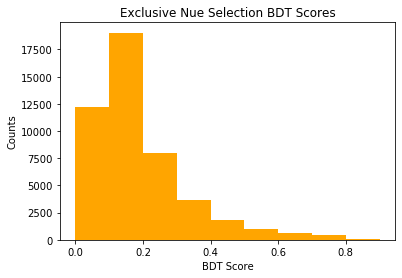

In [35]:
import matplotlib.pyplot as plt
import matplotlib

bins = np.arange(0, 1.0, 0.1)
gen = plt.hist(datasets_bdt['BDT_score'], bins, color='orange')
plt.xlabel("BDT Score")
plt.ylabel("Counts")
plt.title("Exclusive Nue Selection BDT Scores")
plt.show()

In [36]:
NUE_SEL_QUERY = BDT_LOOSE_CUTS
NUE_SEL_QUERY += ' and BDT_score > 0.575'

## Numu Selection

In [37]:
NUMU_SEL_QUERY = 'nslice == 1'
NUMU_SEL_QUERY += ' and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)'
NUMU_SEL_QUERY += ' and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8 '
NUMU_SEL_QUERY += ' and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5 '
NUMU_SEL_QUERY += ' and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 '
NUMU_SEL_QUERY += ' and n_muons_tot > 0'
NUMU_SEL_QUERY += ' and n_protons_tot > 0 '

## Plotter

In [41]:
import plotter_alex
import importlib
importlib.reload(plotter_alex)
scaling = 1

SPLIT = 1.0

numu_nue   = numu_mc.query("(abs(nu_pdg) == 12 & ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55)")

samples = {
    "nue_mc": nue_mc,
    "nue_nue": nue_nue,
    "nue_data": nue_data,
    "nue_dirt": nue_dirt,
    "nue_ext": nue_ext,
    "numu_mc": numu_mc,
    "numu_nue": numu_nue,
    "numu_data": numu_data,
    "numu_dirt": numu_dirt,
    "numu_ext": numu_ext    
}


scaling = 1
# This is the data POT we normalize to (comes from the data Ntuples)
pot =  2e+20 #partial file: 8.885e+19
mcratio   = pot/2.33652e+21 
nueratio  = pot/2.37838e+22 
dirtratio = pot/1.42143e+21
extratio  = 5268051/9199232.74
SPLIT = 1.0
# We scale down the EXT to account for neutrino occupancy
scalingEXT = 0.98
 # We scale down the dirt (big uncertainties on this, there's a better data-MC agreement like this)
scalingDRTnue = 0.35
scalingDRTnumu = 0.60


# NUE
weights = { #full sample mc = 0.38
            "nue_mc"  : mcratio  * SPLIT * scaling,   
            "nue_nue" : nueratio * SPLIT * scaling,  
            "nue_ext" : extratio * SPLIT * scalingEXT, #set0   
            "nue_dirt": dirtratio* SPLIT * scalingDRTnue, #set0 
            "numu_mc"  : mcratio  * SPLIT * scaling,
            "numu_nue"  : mcratio  * SPLIT * scaling,
            "numu_ext" : extratio * SPLIT * scalingEXT,    
            "numu_dirt": dirtratio* SPLIT * scalingDRTnumu, 
}




print (nue_ext.shape)
my_plotter = plotter_alex.Plotter(samples, weights, pot=pot)
print(weights)

#BDT

(6087, 64)
{'nue_mc': 0.08559738414394057, 'nue_nue': 0.008409085175623745, 'nue_ext': 0.5612087579382191, 'nue_dirt': 0.049246181662128984, 'numu_mc': 0.08559738414394057, 'numu_nue': 0.08559738414394057, 'numu_ext': 0.5612087579382191, 'numu_dirt': 0.08442202570650682}


nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8  and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5  and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8  and n_muons_tot > 0 and n_protons_tot > 0 & reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
total  70.6861632853244

SUMS
[0.40496499019282756, 0.9137118550966704, 1.5182433681200074, 2.380076970090129, 4.373361169863612, 6.424926558541857, 10.5889767682497

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Selected numbers =  [6.000 12.000 5.000 4.000 4.000 2.000 1.000 0.000 0.000 0.000]
In bin 0 , eff =  0.004228329809725159  with error =  0.001722555061096672
In bin 1 , eff =  0.0035252643948296123  with error =  0.0010158608364656432
In bin 2 , eff =  0.0016512549537648614  with error =  0.0007378537171689717
In bin 3 , eff =  0.0016467682173734047  with error =  0.0008227058679548943
In bin 4 , eff =  0.0033140016570008283  with error =  0.0016542528982040276
In bin 5 , eff =  0.003816793893129771  with error =  0.0026937253842261484
In bin 6 , eff =  0.0030864197530864196  with error =  0.0030816530788085436
In bin 7 , eff =  0.0  with error =  0.0
In bin 8 , eff =  0.0  with error =  0.0
In bin 9 , eff =  0.0  with error =  0.0

[0.004228329809725159, 0.0035252643948296123, 0.0016512549537648614, 0.0016467682173734047, 0.0033140016570008283, 0.003816793893129771, 0.0030864197530864196, 0.0, 0.0, 0.0]


numu_ratio_nums:
[6497.445178114144, 16818.879500961328, 62882.90922835034, 5706

/home/alex/NuMI/PELEE/plotter_alex.py:2021: RuntimeWarning: divide by zero encountered in double_scalars
  num = numu_wanted_list_smeared[i]*(1/numu_eff[i])
/home/alex/NuMI/PELEE/plotter_alex.py:2021: RuntimeWarning: invalid value encountered in double_scalars
  num = numu_wanted_list_smeared[i]*(1/numu_eff[i])
/home/alex/NuMI/PELEE/plotter_alex.py:3783: RuntimeWarning: invalid value encountered in double_scalars
  res_err = res * np.sqrt((err1/val1)**2 + (err2/val2)**2)
/home/alex/NuMI/PELEE/plotter_alex.py:2200: RuntimeWarning: divide by zero encountered in long_scalars
  ratio_err = self.div_err(n/m, err1, val1, err2, val2)
/home/alex/NuMI/PELEE/plotter_alex.py:2249: RuntimeWarning: divide by zero encountered in long_scalars
  ratio_err = self.div_err(n/m, err1, val1, err2, val2)
/home/alex/NuMI/PELEE/plotter_alex.py:2249: RuntimeWarning: invalid value encountered in long_scalars
  ratio_err = self.div_err(n/m, err1, val1, err2, val2)
/home/alex/NuMI/PELEE/plotter_alex.py:2400: Runt

n =  [3.473 2.145 0.708 0.264 0.064 0.000 0.000 0.000 0.000 0.000]
n =  [2.105 2.027 0.467 0.253 0.050 0.000 0.000 0.000 0.000 0.000]
n =  [2.722 2.208 0.447 0.221 0.083 0.000 0.000 0.000 0.000 0.000]
n =  [2.444 1.854 0.403 0.117 0.087 0.000 0.000 0.000 0.000 0.000]
n =  [2.473 1.854 0.481 0.086 0.125 0.000 0.000 0.000 0.000 0.000]
n =  [2.518 1.582 0.533 0.077 0.073 0.000 0.000 0.000 0.000 0.000]
n =  [2.734 2.271 0.552 0.248 0.085 0.000 0.000 0.000 0.000 0.000]
n =  [2.598 1.749 0.692 0.156 0.037 0.000 0.000 0.000 0.000 0.000]
n =  [2.212 1.831 0.436 0.157 0.074 0.000 0.000 0.000 0.000 0.000]
n =  [2.864 2.184 0.635 0.093 0.146 0.000 0.000 0.000 0.000 0.000]
Universes 10
n =  [3.049 2.104 0.630 0.112 0.051 0.000 0.000 0.000 0.000 0.000]
n =  [3.064 2.080 0.629 0.117 0.047 0.000 0.000 0.000 0.000 0.000]
n =  [2.989 2.050 0.636 0.102 0.058 0.000 0.000 0.000 0.000 0.000]
n =  [3.060 2.131 0.628 0.111 0.054 0.000 0.000 0.000 0.000 0.000]
n =  [3.019 2.064 0.642 0.112 0.050 0.000 0.000 0

NameError: name 'draw_data' is not defined

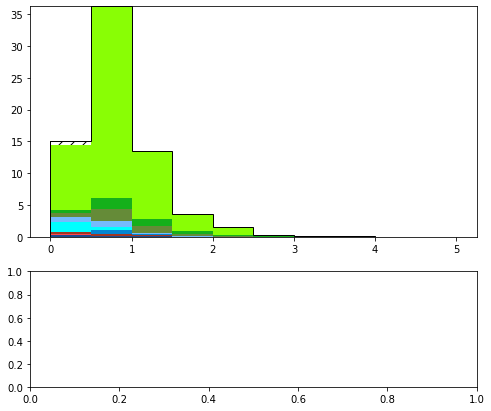

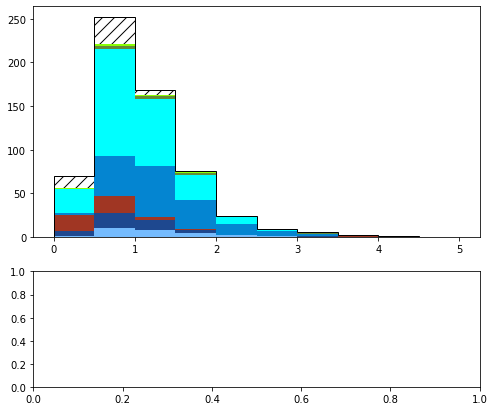

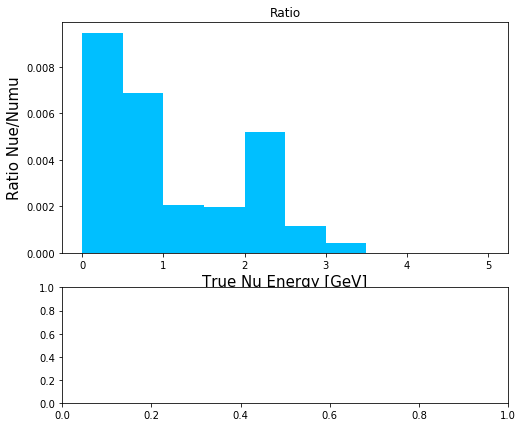

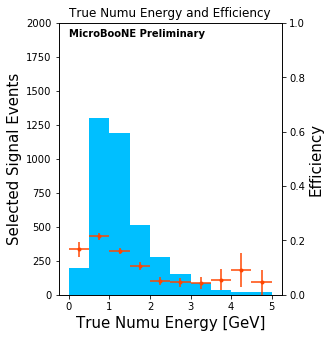

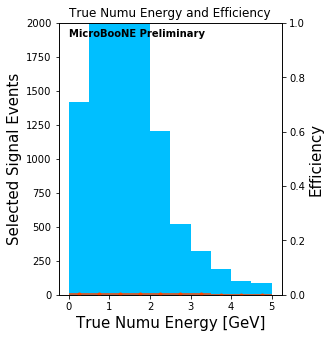

In [42]:
#Now check on a variable

VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"

fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    nue_query= NUE_SEL_QUERY,
    numu_query= NUMU_SEL_QUERY,    
    #kind="interaction",
    kind="event_category",
    draw_sys  = True, 
    draw_geoSys = True, 
    draw_data = True,
    genieweight = "weightSplineTimesTuneTimesPPFX",  
    stacksort=3,
    title=XTIT,
    bins=BINS,
    range=RANGE
)[0:3]

ax1.set_title('NuMI Run 1, FHC, Nue - Reconstructed Energies',loc='left')
#ax1.set_yscale("log")
fig.tight_layout()